In [99]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Instructions

Pick a dataset of your choice with a binary outcome and the potential for at least 15 features. If you're drawing a blank, the crime rates in 2013 dataset has a lot of variables that could be made into a modelable binary outcome.

Engineer your features, then create three models. Each model will be run on a training set and a test-set (or multiple test-sets, if you take a folds approach). The models should be:

- Vanilla logistic regression
- Ridge logistic regression
- Lasso logistic regression

If you're stuck on how to begin combining your two new modeling skills, here's a hint: the SKlearn LogisticRegression method has a "penalty" argument that takes either 'l1' or 'l2' as a value.

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

# Load and clean

This dataset contains detailed stats for all basketball games in the 2017-2018 NBA season.  I'm going to work on predicting wins and losses based on all stats that have nothing to do with shooting and scoring.

In [2]:
raw_games_df = pd.read_csv("2017-18_teamBoxScore.csv")
raw_games_df.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2017-10-17,08:00,Regular,Forte,Brian,Smith,Michael,McCutchen,Monty,BOS,...,55.5208,101.7143,98.7227,2.9916,0.4176,14.6154,1.1176,17.6471,100.2809,99.8648
1,2017-10-17,08:00,Regular,Forte,Brian,Smith,Michael,McCutchen,Monty,CLE,...,62.5519,98.7227,101.7143,-2.9916,0.3956,17.7778,2.0000,91.6667,100.2809,100.2809
2,2017-10-17,10:30,Regular,Maddox,Tre,Garretson,Ron,Foster,Scott,HOU,...,86.2033,118.0353,119.0108,-0.9755,0.4725,24.2442,2.0000,29.4118,102.5117,102.9406
3,2017-10-17,10:30,Regular,Maddox,Tre,Garretson,Ron,Foster,Scott,GS,...,81.9038,119.0108,118.0353,0.9755,0.4700,19.1309,2.1538,69.2308,102.5117,102.0863
4,2017-10-18,07:00,Regular,Davis,Marc,Boland,Matt,DeRosa,Joe,CHA,...,70.7113,103.0506,90.9270,12.1236,0.4271,17.8731,2.6667,155.5556,98.9805,99.8123


First, lets calculate a binary W/L column and delete all the points-related columns.

In [85]:
raw_games_df['win'] = raw_games_df['teamRslt'].str.contains('Win')
raw_games_df['margin'] = raw_games_df['teamPTS'] - raw_games_df['opptPTS']
raw_games_df['3pt_proportion'] = round(raw_games_df['team3PA']/raw_games_df['teamFGA'],2)*100
raw_games_df['1q_points_pct'] = round(raw_games_df['teamPTS1']/raw_games_df['teamPTS'],2)*100
raw_games_df['2q_points_pct'] = round(raw_games_df['teamPTS2']/raw_games_df['teamPTS'],2)*100
raw_games_df['3q_points_pct'] = round(raw_games_df['teamPTS3']/raw_games_df['teamPTS'],2)*100
raw_games_df['4q_points_pct'] = round(raw_games_df['teamPTS4']/raw_games_df['teamPTS'],2)*100
raw_games_df['oppt1q_points_pct'] = round(raw_games_df['opptPTS1']/raw_games_df['opptPTS'],2)*100
raw_games_df['oppt2q_points_pct'] = round(raw_games_df['opptPTS2']/raw_games_df['opptPTS'],2)*100
raw_games_df['oppt3q_points_pct'] = round(raw_games_df['opptPTS3']/raw_games_df['opptPTS'],2)*100
raw_games_df['oppt4q_points_pct'] = round(raw_games_df['opptPTS4']/raw_games_df['opptPTS'],2)*100

# drop irrelevant columns
irrelevant_droplist = [
    'offLNm1',
    'offFNm1',
    'offLNm2',
    'offFNm2',
    'offLNm3',
    'offFNm3',
    'teamAbbr',
    'teamMin',
    'opptAbbr',
    'opptLoc',
    'opptMin',
]

# drop clumns that are just proxies for points - uninteresting for win prediction:
points_droplist = [
    'teamRslt',
    'teamFGA',
    'team3PA',
    'teamFGM',
    'team2PA',
    'team3PM',
    'teamFTM',
    'teamPTS',
    'teamPTS1',
    'teamPTS2',
    'teamPTS3',
    'teamPTS4',
    'teamPTS5',
    'teamPTS6',
    'teamPTS7',
    'teamPTS8',
    'opptRslt',
    'opptFGA',
    'oppt3PA',
    'oppt2PA',
    'opptFGM',
    'oppt3PM',
    'opptFTM',
    'opptPTS',
    'opptPTS1',
    'opptPTS2',
    'opptPTS3',
    'opptPTS4',
    'opptPTS5',
    'opptPTS6',
    'opptPTS7',
    'opptPTS8',
    'teamFIC',
    'teamFIC40',
    'teamOrtg',
    'teamDrtg',
    'teamEDiff',
    'teamPlay%',
    'teamAR',
    'opptFIC',
    'opptFIC40',
    'opptOrtg',
    'opptDrtg',
    'opptEDiff',
    'opptPlay%',
    'opptAR',    
]

nonscoring_quant_cols = [
    'teamDayOff',
    'teamAST',
    'teamTO',
    'teamSTL',
    'teamBLK',
    'teamPF',
    'teamORB',
    'teamDRB',
    'teamTRB',
    'teamTREB%',
    'teamASST%',
    'teamOREB%',
    'teamDREB%',
    'teamTO%',
    'teamSTL%',
    'teamBLK%',
    'teamBLKR',
    'teamAST/TO',
    'teamSTL/TO',
    'opptDayOff',
    'opptAST',
    'opptTO',
    'opptSTL',
    'opptBLK',
    'opptPF',
    'opptORB',
    'opptDRB',
    'opptTRB',
    'opptTREB%',
    'opptASST%',
    'opptOREB%',
    'opptDREB%',
    'opptTO%',
    'opptSTL%',
    'opptBLK%',
    'opptBLKR',
    'opptAST/TO',
    'opptSTL/TO',
    'poss',
    'pace',
    'win',
    'margin'
]

droplist = irrelevant_droplist + points_droplist
# games_df = raw_games_df.drop(droplist, axis=1)

games_df = raw_games_df[nonscoring_quant_cols].copy()
games_df.drop('margin', axis=1, inplace=True) # we'll revisit this later
print(len(games_df))
games_df.head()

2460


,teamDayOff,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamORB,teamDRB,teamTRB,teamTREB%,...,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptAST/TO,opptSTL/TO,poss,pace,win
0,0,24,12,11,4,24,9,37,46,47.9167,...,82.0000,15.3153,2.9916,3.9888,6.5574,1.1176,17.6471,100.2809,99.8648,False
1,0,19,17,3,4,25,9,41,50,52.0833,...,80.4348,10.8108,10.9692,3.9888,7.1429,2.0000,91.6667,100.2809,100.2809,True
2,0,28,13,9,5,16,10,33,43,51.1905,...,85.3659,16.0015,4.8775,8.7795,18.0000,2.0000,29.4118,102.5117,102.9406,True
3,0,34,17,5,9,25,6,35,41,48.8095,...,76.7442,10.9834,8.7795,4.8775,8.9286,2.1538,69.2308,102.5117,102.0863,False
4,0,16,17,4,3,15,3,44,47,50.0000,...,80.8511,8.1610,14.1442,3.0309,4.2857,2.6667,155.5556,98.9805,99.8123,False


Looks like we've got a bunch of percentages getting read as strings (objects) that need to be converted to integers.  Let's take care of that:

In [86]:
for column in games_df:
    if column.endswith('%'):
        games_df[column] = pd.to_numeric(games_df[column])

And fortunately, we have no nulls in this dataset - so we're pretty much good to go here.

In [87]:
games_df.isnull().sum().sum()

0

# Testing models: plain logistic regression

First, let's set up our data:

In [88]:
from sklearn import model_selection

# games_df.drop(more_drops, axis=1, inplace=True)

# drop categorical columns
categorical_cols = []
for column in games_df:
    if column != 'win' and games_df[column].dtype not in ['int64', 'float64']:
        categorical_cols.append(column)
games_df.drop(categorical_cols, axis=1, inplace=True)      

# split into train and test datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(games_df.drop('win', axis=1), games_df['win'])

Now we'll try the basic logistic regression model:

In [33]:
from sklearn import linear_model

logr_model = linear_model.LogisticRegression(C=1e9)
logr_model.fit(X_train, y_train)
train_acc = logr_model.score(X_train, y_train)
test_acc = np.mean(model_selection.cross_val_score(logr_model, games_df.drop('win', axis=1), games_df['win'], cv=4))
print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))


Training set accuracy: 0.9143631436314363
Test set accuracy: 0.9073287258344261


# Testing models: ridge logistic regression

The basic logistic regression showed minimal overfitting (the test score was basically just as good as the training score), so we may not see much difference here.

In [45]:
logRidge_model = linear_model.LogisticRegression(C=1)
logRidge_model.fit(X_train, y_train)
train_acc = logRidge_model.score(X_train, y_train)
test_acc = np.mean(model_selection.cross_val_score(logRidge_model, games_df.drop('win', axis=1), games_df['win'], cv=4))
print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))

Training set accuracy: 0.9132791327913279
Test set accuracy: 0.9093579466136469


In [60]:
powers = range(-6,6)
train_acc = []
test_acc = []
for power in powers:
    lambda_ = 10**power
    c = 1/lambda_
    logRidge_model = linear_model.LogisticRegression(C=c)
    logRidge_model.fit(X_train, y_train)
    train_acc.append(logRidge_model.score(X_train, y_train))
    test_acc.append(
        np.mean(model_selection.cross_val_score(logRidge_model, games_df.drop('win', axis=1), games_df['win'], cv=4))
    )

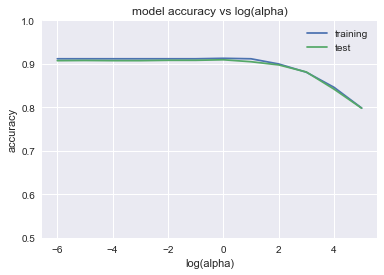

In [61]:
plt.plot(powers, train_acc, label="training")
plt.plot(powers, test_acc, label="test")
plt.title("model accuracy vs log(lambda)")
plt.xlabel('log(lambda)')
plt.ylabel('accuracy')
plt.ylim(0.5,1)
plt.legend()
plt.show()

As predicted, regularization doesn't make much difference (unless you way, way overregularize) because there's no overfitting here - i.e., we have plenty of data.  However, if we reduce the number of examples by an order of 10, we'll see very different results:

In [53]:
# DROP 90% OF OUR DATA:
mini_games_df = games_df.sample(frac=0.1)

# drop categorical columns
categorical_cols = []
for column in mini_games_df:
    if column != 'win' and mini_games_df[column].dtype not in ['int64', 'float64']:
        categorical_cols.append(column)
mini_games_df.drop(categorical_cols, axis=1, inplace=True)      

# split into train and test datasets
Xm_train, Xm_test, ym_train, ym_test = model_selection.train_test_split(mini_games_df.drop('win', axis=1), mini_games_df['win'])

In [54]:
logRidge_model = linear_model.LogisticRegression(C=1)
logRidge_model.fit(Xm_train, ym_train)
train_acc = logRidge_model.score(Xm_train, ym_train)
test_acc = np.mean(model_selection.cross_val_score(logRidge_model, mini_games_df.drop('win', axis=1), mini_games_df['win'], cv=4))
print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))

Training set accuracy: 0.9456521739130435
Test set accuracy: 0.8657456372289793


In [55]:
powers = range(-6,6)
min_train_acc = []
min_test_acc = []
for power in powers:
    lambda_ = 10**power
    c = 1/lambda_
    logRidge_model = linear_model.LogisticRegression(C=c)
    logRidge_model.fit(Xm_train, ym_train)
    min_train_acc.append(logRidge_model.score(Xm_train, ym_train))
    min_test_acc.append(
        np.mean(model_selection.cross_val_score(logRidge_model, mini_games_df.drop('win', axis=1), mini_games_df['win'], cv=4))
    )

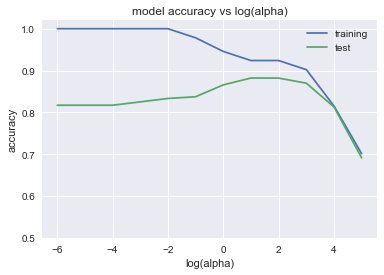

In [56]:
plt.plot(powers, min_train_acc, label="training")
plt.plot(powers, min_test_acc, label="test")
plt.title("model accuracy vs log(lambda)")
plt.xlabel('log(lambda)')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0.5,1.02)
plt.show()

Voila!  Now we've got the prototypical learning curve for lambda values: 
- at low labmda values we have a high-variance model with high training scores and low test scores
- at medium lambda values we get a balanced model with good scores for both
- at high lambda values we get a high-bias model with low scores across the board from overzealous regularization

# Testing models: lasso logistic regression

In [67]:
logRidge_model = linear_model.LogisticRegression(penalty='l1')
logRidge_model.fit(X_train, y_train)
train_acc = logRidge_model.score(X_train, y_train)
test_acc = np.mean(model_selection.cross_val_score(logRidge_model, games_df.drop('win', axis=1), games_df['win'], cv=4))
print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))

Training set accuracy: 0.9121951219512195
Test set accuracy: 0.9085462583019586


Basically the same scores as the others, but with longer time.  Let's see what variables it selected as significant:

In [75]:
coefs = logRidge_model.coef_[0]
labeled_coefs = []
for i in range(len(coefs)):
    label = games_df.drop('win', axis=1).columns[i]
    labeled_coefs.append((label, coefs[i]))
labeled_coefs = sorted(labeled_coefs, key=lambda x: -abs(x[1]))
labeled_coefs

[('teamAST', 0.8283553876199359),
 ('opptAST', -0.7477060696675051),
 ('opptBLK', 0.6882331131146174),
 ('teamTREB%', 0.6682862237960023),
 ('opptAST/TO', -0.6116358181062993),
 ('opptBLKR', -0.5656470211396082),
 ('teamBLK%', -0.5083381902400722),
 ('teamBLKR', 0.48363204205453725),
 ('opptTO', 0.44355504809374463),
 ('teamTO', -0.3521594038748265),
 ('teamBLK', -0.32715242852509874),
 ('teamASST%', -0.294820101107898),
 ('opptBLK%', 0.28242869538532267),
 ('opptASST%', 0.2746109935087145),
 ('teamOREB%', -0.26921423395589106),
 ('teamDREB%', -0.26335748847716506),
 ('opptPF', 0.25074845084067093),
 ('teamPF', -0.2336357656432593),
 ('opptTO%', -0.22069989463253686),
 ('opptTREB%', -0.21802714995434108),
 ('teamDayOff', -0.11180409403533571),
 ('opptOREB%', 0.10284925434961338),
 ('opptSTL', -0.09703042863089646),
 ('teamSTL%', 0.08373882970626695),
 ('teamTO%', 0.08301736422809204),
 ('opptDREB%', 0.08169311658143655),
 ('opptORB', -0.07849276716621599),
 ('poss', -0.0400688611027207

Because these features aren't normalized, we can't really rely on those coefficient values as a measure of importance.  We can look at the values it zeroed out, however.  It turns out it only zeroed out the stats that were redundant - e.g., opptTRB, opponent total rebounds, is redundant with the rebound percentage and total possessions.  So basically, this didn't drop any real features as significant, only redundant ones.

And then let's try the learning curves on a small subset of our data, like we did with the ridge regression:

In [66]:
logRidge_model = linear_model.LogisticRegression(penalty='l1')
logRidge_model.fit(Xm_train, ym_train)
train_acc = logRidge_model.score(Xm_train, ym_train)
test_acc = np.mean(model_selection.cross_val_score(logRidge_model, games_df.drop('win', axis=1), games_df['win'], cv=4))
print("Training set accuracy: {}".format(train_acc))
print("Test set accuracy: {}".format(test_acc))

Training set accuracy: 0.9293478260869565
Test set accuracy: 0.9065170375227378


Interesting: there's very little overfitting here even with small data.  Whatever sklearn's default setting is (maybe still C=1, but the results below throw the relevance of C into deep doubt), it seems to work pretty well.

In [78]:
powers = range(-4,6)
min_train_acc = []
min_test_acc = []
for power in powers:
    lambda_ = 10**power
    c = 1/lambda_
    logRidge_model = linear_model.LogisticRegression(penalty='l1')
    logRidge_model.fit(Xm_train, ym_train)
    min_train_acc.append(logRidge_model.score(Xm_train, ym_train))
    min_test_acc.append(
        np.mean(model_selection.cross_val_score(logRidge_model, mini_games_df.drop('win', axis=1), mini_games_df['win'], cv=4))
    )

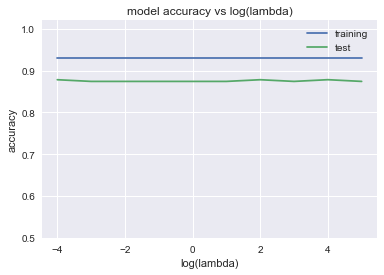

In [79]:
plt.plot(powers, min_train_acc, label="training")
plt.plot(powers, min_test_acc, label="test")
plt.title("model accuracy vs log(lambda)")
plt.xlabel('log(lambda)')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0.5,1.02)
plt.show()

What we learn here: setting lambda/C makes absolutely no difference for sklearn's lasso logistic regression.  My guess is that C is being ignored because it's using a different default for lasso / l1 regression, but I can't find anything in the documentation to confirm or deny that.

# Testing models: for fun - Random Forest classifier

In [94]:
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
cv_scores = model_selection.cross_val_score(rfc, games_df.drop('win', axis=1), games_df['win'], cv=4)

print(cv_scores)
print("mean score: " + str(np.mean(cv_scores)) + "\n")

[0.80357143 0.78733766 0.76872964 0.79478827]
mean score: 0.7886067515546342



In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time

rfc = ensemble.RandomForestClassifier()
param_dist = {"n_estimators":[5,10,20,30],
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rSearch = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=30)

start_time = time.time()
rSearch.fit(X_train, y_train)
print("Best score:")
print(rSearch.best_score_)
print("Best parameters:")
print(rSearch.best_params_)
print("Elapsed time: "+ str((time.time() - start_time)))
                            

Best score:
0.8146341463414634
Best parameters:
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 20}
Elapsed time: 4.582831859588623


Looks like even with the very best parameters, Random Forest can only achieve an accuracy of about 81% - way less than logistic regression.  

# QUESTION: why is random forest so ineffective here??

I'd sort of assumed that RF would be more effective than logistic regression.  Instead it disappoints pretty badly here.

# Conclusions

My dataset here has enough data that it doesn't overfit even without regularization.  So it doesn't really make much difference which model I use here.  The only exception would be if I want to work on feature selection, in which case Lasso could be helpful.